In [1]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
positive_steps = [7500, 15000, 30000, 64007]
negative_steps = [2250, 4500, 8976]
df = pd.read_csv("kick.csv")
assert df.shape[0] == (positive_steps[-1] + negative_steps[-1])

In [3]:
import re

def clean_string(s):
    return re.sub('[^A-Za-z0-9]+', "_", str(s))



def get_dataset(max_positive=4000000000, max_negative=4000000000):
    data = pd.read_csv("kick.csv")
    data = (
        pd
        .concat([
            data[data['IsBadBuy'] == 0][:max_positive],
            data[data['IsBadBuy'] != 0][:max_negative]
        ])
        .sample(frac=1)
        .reset_index(drop=True)
    )
    target = data["IsBadBuy"].apply(lambda x: 1.0 if x == 0 else 0)
    data["PurchYear"] = pd.DatetimeIndex(data['PurchDate']).year
    data["PurchMonth"] = pd.DatetimeIndex(data['PurchDate']).month
    data["PurchDay"] = pd.DatetimeIndex(data['PurchDate']).day
    data["PurchWeekday"] = pd.DatetimeIndex(data['PurchDate']).weekday
    data.drop(["RefId", "IsBadBuy", "PurchDate"], axis=1, inplace=True)
    categorical_features = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34}
    for i in categorical_features:
        data[data.columns[i]] = data[data.columns[i]].apply(clean_string)
    columns_to_impute = []
    for i, column in enumerate(data.columns):
        if i not in categorical_features and pd.isnull(data[column]).any():
            columns_to_impute.append(column)
    for column_name in columns_to_impute:
        data[column_name + "_imputed"] = pd.isnull(data[column_name]).astype(float)
        data[column_name].fillna(0, inplace=True)
    for i, column in enumerate(data.columns):
        if i not in categorical_features:
            data[column] = data[column].astype(float)
    return data, target, [data.columns[x] for x in categorical_features]


# Catboost

In [4]:
catboost_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
catboost_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        X, y, cat_features = get_dataset(positive, negative)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': cat_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras

In [15]:
keras_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
keras_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        X, y, cat_features = get_dataset(positive, negative)

        columns_to_onehot_encode = [x for x in cat_features if X[x].nunique() <= 50]
        columns_to_integer_encode = [x for x in cat_features if X[x].nunique() > 50]
        for col in X.columns:
            if col in columns_to_integer_encode:
                X[col] = X[col].astype('category').cat.codes.astype('float32')
            if col not in cat_features or col in columns_to_integer_encode:
                if X[col].max() == X[col].min():
                    col_range = 1
                else:
                    col_range = X[col].max() - X[col].min()
                X[col] = (X[col] - X[col].min()) / col_range
        X = pd.get_dummies(X, columns=columns_to_onehot_encode)

        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=0,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=False,
            )
        ]
        model.fit(
            X_train, y_train,
            epochs=16, validation_data=(X_valid, y_valid),
            callbacks=callbacks, verbose=False,
        )

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = model.predict_classes(X_valid).mean()

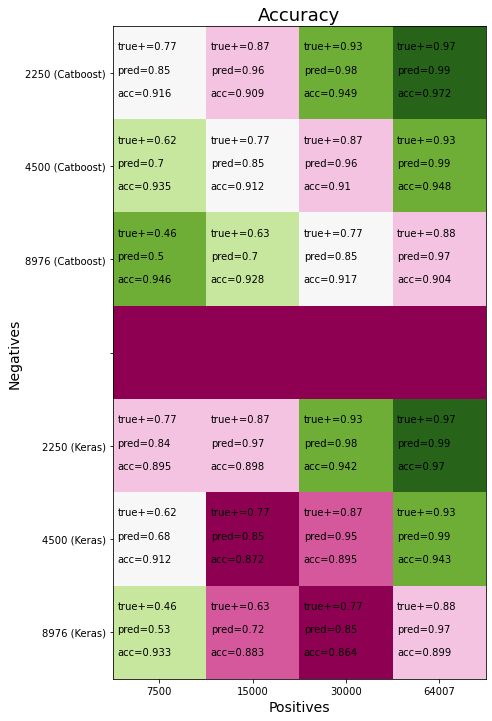

In [16]:
cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(9, 12))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(positive_steps)), positive_steps)
plt.yticks(
    range(len(negative_steps)*2+1),
    [f'{x} (Catboost)' for x in negative_steps] + [''] + [f'{x} (Keras)' for x in negative_steps]
)
for i in range(len(negative_steps)):
    for j in range(len(positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(negative_steps) + 1, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')

# Plot Keras training

In [12]:
X, y, cat_features = get_dataset()
columns_to_onehot_encode = [x for x in cat_features if X[x].nunique() <= 50]
columns_to_integer_encode = [x for x in cat_features if X[x].nunique() > 50]
for col in X.columns:
    if col not in cat_features:
        if X[col].max() == X[col].min():
            col_range = 1
        else:
            col_range = X[col].max() - X[col].min()
        X[col] = (X[col] - X[col].min()) / col_range
    if col in columns_to_integer_encode:
        X[col] = X[col].astype('category').cat.codes
X = pd.get_dummies(X, columns=columns_to_onehot_encode)
X = X.astype('float32')
y = y.astype('float32')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

scores = {}

In [13]:
for dropout_value in tqdm([0.25, 0.4, 0.5]):
    for layer1 in tqdm([32, 64, 128], leave=False):
        for layer2 in [32, 64, 128]:
            for layer3 in [0, 16]:
                layers = [
                    keras.layers.Dense(layer1, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                    keras.layers.Dense(layer2, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                ]
                if layer3:
                    layers += [
                        keras.layers.Dense(layer3, activation='relu'),
                        keras.layers.Dropout(dropout_value),
                    ]
                layers += [
                    keras.layers.Dense(1, activation='sigmoid'),
                ]
                model = keras.Sequential(layers)
                model.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=0,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=False,
                    )
                ]
                history = model.fit(
                    X_train, y_train,
                    epochs=16, validation_data=(X_valid, y_valid),
                    callbacks=callbacks, verbose=False,
                )

                test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
                key = 'l1_{}_l2_{}_l3_{}_dr_{}'.format(layer1, layer2, layer3, dropout_value)
                scores[key] = history.history['val_accuracy']

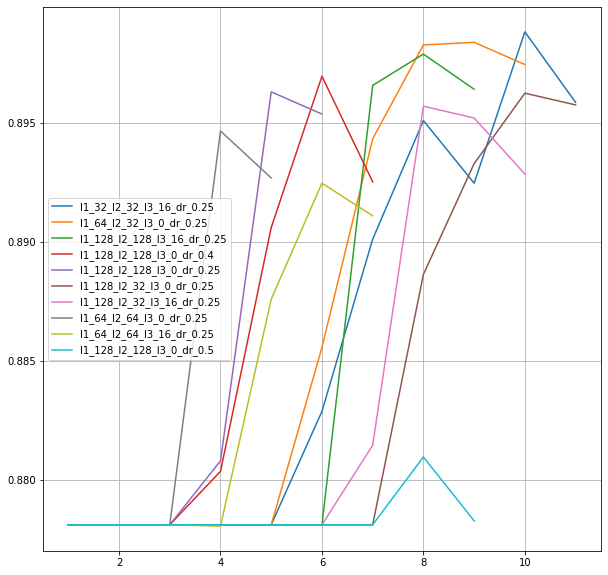

In [14]:
by_max = {(max(values), key): key for (key, values) in scores.items()}
best_key = [by_max[x] for x in sorted(by_max, reverse=True)[:10]]
plt.figure(figsize=(10, 10))
plt.grid(True)
for key in best_key:
    plt.plot(range(1, len(scores[key])+1), scores[key], label=key)
plt.legend()
plt.show()